# Extending Logistic Regression: 2015 American Community Survey

## Conrad Appel, Erik Gabrielsen, Danh Nguyen

### Preparation and Overview (30 points total)

[5 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results.

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

[15 points] Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue for or against splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

### Modeling (50 points total)

[20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template used in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1/L2 norm of the weights). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

[15 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

[15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time, training iterations, and memory usage while training. Discuss the results. 

### Deployment (10 points total)

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

### Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Make your implementation of logistic regression compatible with the GridSearchCV function that is part of scikit-learn.

## Data Overview

In this lab, we are investigating the relationship among working individuals' income and personal attributes as provided by the [2015 American Community Survey](https://www.kaggle.com/census/2015-american-community-survey). We used a subset of the entire dataset, which gave us around 1.5 million individual records to work with. In the interest of computation time (especially with GridSearchCV), we used about 500,000 records.

Specifically, we want to see how well we can classify people's income based on their age, race, education level, degree, where they were born, marital status, military status, and time when they arrive and leave work. 

Marketing and advertising researchers may be interested in our work. They can try to predict their target audience's income based on certain attributes to determine how they should price their products. They can use this to bolster their market research surveys and see how their samples compare to census data.


In [20]:
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score
from scipy.optimize import fmin_bfgs
from scipy.special import expit

In [2]:
%load_ext memory_profiler

In [64]:
number_of_rows = 50000 # None to get all

%time df = pd.read_csv('~/Downloads/ss15pusb.csv', nrows=number_of_rows)

CPU times: user 1.69 s, sys: 178 ms, total: 1.87 s
Wall time: 1.9 s


In [58]:
print('Look at all these columns we have to work with! \n\n'+str(list(df.columns.values)))

Look at all these columns we have to work with! 

['RT', 'SERIALNO', 'SPORDER', 'PUMA', 'ST', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTR', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'RELP', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKW', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FHICOVP', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACA

In [65]:
# But let's bring the number of columns down to something more reasonable...
cols_to_save = ['AGEP','PINCP', 'MAR', 'MIL', 'SCHL','QTRBIR','JWAP','JWDP','YOEP','WAOB','RAC1P', 'FOD1P']
new_df = df.filter(items=cols_to_save)
list(new_df.columns.values)

['AGEP',
 'PINCP',
 'MAR',
 'MIL',
 'SCHL',
 'QTRBIR',
 'JWAP',
 'JWDP',
 'YOEP',
 'WAOB',
 'RAC1P',
 'FOD1P']

## Data Preparation 

We began with approximately 1.5 million records from the dataset and kept approximately 12 attributes of the almost 300 attributes tracked by the survey, and wrote it out to a CSV for reuse later on. Of the attributes we examine, Age, Personal Income, and Year of entry to the US are ordinal data represented as integers. The remaining attributes were recorded as discrete values in the dataset, and we continue using their integer representation. For instance, Time of Arrival at work is recorded as 1 for times between 12:00 a.m. and 12:04 a.m. For classification purposes, we cut income into fifths, with 0 being the 20% of people with the lowest income. The full list of attributes we are working with is displayed in the table below.


**Attribute**|**Description**|**Example**
:-----:|:-----:|:-----:
AGEP|Age| 
PINCP|Total person's income (signed)| 0 - bottom 20% of population, 4 - top 20% of population
YOEP|Year of entry to the US| 
QTRBIR|Quarter of birth|1 - January through March, 2 -  April through June, etc.
JWAP|Time of arrival at work |1 - 12:00 a.m. to 12:04 a.m., 2 - 12:05 a.m. to 12:09 a.m., etc.
JWDP|Time of departure for work|1 - 12:00 a.m. to 12:29 a.m., 2 - 12:30 a.m. to 12:59 a.m., etc.
WAOB|World area of birth|1 - US state, 2 - PR and US Island Areas, etc.
RAC1P|Recoded detailed race code|1 - White alone, 2 - Black or African American alone, etc.
MAR|Marital status|1 - Married, 2 - Widowed
MIL|Military Service |1 - Now on active duty, 4 - Never served in the military
SCHL|Educational attainment|23 - Professional degree beyond a bachelor's degree, 24 - Doctorate degree, etc.
FOD1P|Recoded field of degree|1904 - advertising and public relations, 2001 - communication technologies, etc.

### Data Cleaning 

We delete all of the records younger than 18 to exclude the set to working individuals. Time of arival and departure are `NAN` for those who are not working or working at home, so we map this to a discrete value of 0. We also map the `NAN` values for those who were born in the United States to the year they were born for Year of Entry. For Field of Degree, we map `NAN` to 0 for those that do not have at least a bachelor's degree. We then use quantile cut divide income into fifths for classification purpose.

In [66]:
# delete younger than 18
new_df = new_df[new_df.AGEP >= 18]

In [67]:
# find null columns
print('Columns that contain nulls: '+str(new_df.columns[new_df.isnull().any()].tolist()))

Columns that contain nulls: ['JWAP', 'JWDP', 'YOEP', 'FOD1P']


In [68]:
# clean out JWAP and JWDP. They are ordinal variables, create a new one to classify them
new_df['JWAP'].fillna(0, inplace=True)
new_df['JWDP'].fillna(0, inplace=True)
new_df['FOD1P'].fillna(0, inplace=True)

## fill null values in YOEP (Year of entrance into US)
new_df['YOEP'].fillna((2015 - new_df['AGEP']), inplace=True)
new_df['YOEP'] = new_df['YOEP'].astype(np.int)

In [69]:
# make sure we took care of them all
print('Are we good? '+('Yes!' if len(new_df.columns[new_df.isnull().any()].tolist()) == 0 else 'No...'))

Are we good? Yes!


In [70]:
new_df['PINCP'] = pd.qcut(new_df.PINCP, 5, labels=[0,1,2,3,4])
new_df['PINCP'].unique()

[1, 0, 2, 4, 3]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [71]:
new_df['PINCP'] = new_df['PINCP'].astype(np.int)

In [13]:
print('Number of people in each class:')
for value in new_df.PINCP.unique(): 
    print(str(value)+': ' +str(len(new_df[new_df['PINCP'] == value])))

Number of people in each class:
1: 80754
0: 79793
2: 78349
4: 79469
3: 79608


In [72]:
# Show final datatypes
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39559 entries, 0 to 49999
Data columns (total 12 columns):
AGEP      39559 non-null int64
PINCP     39559 non-null int64
MAR       39559 non-null int64
MIL       39559 non-null float64
SCHL      39559 non-null float64
QTRBIR    39559 non-null int64
JWAP      39559 non-null float64
JWDP      39559 non-null float64
YOEP      39559 non-null int64
WAOB      39559 non-null int64
RAC1P     39559 non-null int64
FOD1P     39559 non-null float64
dtypes: float64(5), int64(7)
memory usage: 3.9 MB


### Training and Test Sets

We used scikit learn to randomly select 80% of our dataset for training classifiers and 20% of our dataset for testing. Since we used quantile cut to evenly split our dataset and balance the income classes, the 80-20 split is appropriate for our purposes

In [73]:
# We need to get a copy of the data and the "targets" as numpy matrices for training (rather than Pandas DataFrames)
df_imputed = new_df.copy()
if 'PINCP' in new_df:
    y = df_imputed['PINCP'].values # get a copy of the target classes
    del df_imputed['PINCP'] # get rid of the class column
    X = df_imputed.values # use everything else to predict!    
    
# We use a Scikit Learn Cross-Validation object to split our data into training/testing subsets
cv_object = ShuffleSplit(train_size=.8, test_size=0.2, n_splits=1)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=0.8)


## Modeling

Here we will apply scikit-learn's logistic regression classifier along with our custom classifier on the dataset. In the first part, we can determine the accuracy of scikit-learn's logistical regression on our data set and break it down by each prediction class (the personal income brackets). While the overall accuracy is better than chance (approximately 43%), the most accurately predicted classes are class 0, and 4. In other words, we can classify those in the bottom and top 20% income brackets based on population, but not those in between. This could be due to a large number of people earning around the same income, thereby making it harder to distinguish the middle classes.

In [41]:
# run logistic regression and vary some parameters

# first we create a reusable sklearn logisitic regression object
lr_clf = LogisticRegression()

# now we can use the cv_object that we setup before to iterate through the 
# different training and testing sets. Each time we will reuse the logisitic regression 
# object, but it gets re-trained on different data each time we use it.

iter_num=0
for train_indices, test_indices in cv_object.split(X):
    print("==== Iteration",iter_num,"====")
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    %time %memit lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    for i in range(0,len(conf)):
        print("Accuracy for income bracket", i, ":",conf[i][i]/sum(conf[i]))
    print("Overall accuracy:", acc )
    print("Confusion matrix\n",conf)
    iter_num += 1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

==== Iteration 0 ====
peak memory: 570.30 MiB, increment: 1.94 MiB
CPU times: user 21.2 s, sys: 268 ms, total: 21.4 s
Wall time: 22.2 s
Accuracy for income bracket 0 : 0.685490598729
Accuracy for income bracket 1 : 0.403418489248
Accuracy for income bracket 2 : 0.184794494115
Accuracy for income bracket 3 : 0.231913962359
Accuracy for income bracket 4 : 0.652733915413
Overall accuracy: 0.432062315472
Confusion matrix
 [[10682  2451   823   516  1111]
 [ 4377  6585  2019  1432  1910]
 [ 2231  4304  2873  2946  3193]
 [ 1325  2109  2699  3709  6151]
 [ 1061   894  1332  2321 10541]]


We normalize the confusion matrices into percentages of the true class that was predicted to produce the heatmap below. 

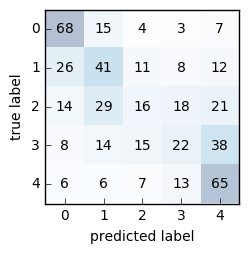

In [28]:
conf2 = conf.copy()
for i in range(0,len(conf2)):
    class_total = sum(conf2[i])
    for j in range(0, len(conf2)):
        conf2[i][j] = conf2[i][j]/class_total*100
        
fig, ax = plot_confusion_matrix(conf_mat=conf2)
plt.show()

### Custom Logistic Regression Classifier

We then applied our custom one-versus-all classifier. Our classifier allows users to specify L1 or L2 regularization and choose their optimization method: newton, steepest descent, or stochastic descent. 

In [30]:
# Different types of binary classifiers inherit from this and redefine methods as necessary
class BinaryClassifierBase:
    def __init__(self, eta, iters=20, cost=0.001, norm=2):
        self.eta = eta
        self.cost = cost
        self.iters = iters
        self.norm = norm
    
    def normalize(self, w, gradient):
        # regularization (adds both if 3)
        if self.norm & 1: # L1 norm
            gradient[1:] += -1 * w[1:] * self.cost
        elif self.norm & 2: # L2 norm
            gradient[1:] += -2 * w[1:] * self.cost
    
    def fit(self, x, y):
        self.w_ = np.zeros((x.shape[1],1))
        for _ in range(self.iters):
            gradient = self._get_gradient(x,y) # gradient calculation must be defined in subclass!
            self.normalize(self.w_, gradient)
            self.w_ += gradient*self.eta
    
    def predict_proba(self,x):
        return 1/(1+np.exp(-(x @ self.w_))) # sigmoid
    
    def predict(self, x):
        return (self.predict_proba(x)>0.5) # choose the class that has a greater probability
    
    
# Uses the Stochastic Gradient Descent Algorithm (random movements - saves time!)
class BinaryStochDescClassifier(BinaryClassifierBase):
    def _get_gradient(self, x, y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(x[idx]) # get difference from target
        gradient = x[idx] * ydiff[:,np.newaxis]
        gradient = gradient.reshape(self.w_.shape)
        return gradient    
    
# Uses the Steepest Gradient Descent algorithm
class BinarySteepDescClassifier(BinaryClassifierBase):
    def _get_gradient(self, x, y):
        ydiff = y-self.predict_proba(x).ravel()
        gradient = np.mean(x * ydiff[:,np.newaxis], axis=0)
        return gradient.reshape(self.w_.shape)

# Uses BFGS, similar to Newton's Method
class BinaryNewtonClassifier(BinaryClassifierBase):
    def fit(self, x, y):
        def obj_fn(w, x, y, c):
            g = expit(x @ w)
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + c*sum(w**2)
        
        def obj_grad(w, x, y, c):
            g = expit(x @ w)
            ydiff = y-g
            gradient = np.mean(x * ydiff[:,np.newaxis], axis=0)
            gradient = gradient.reshape(w.shape)
            self.normalize(w, gradient)
            return -gradient
        
        self.w_ = fmin_bfgs(obj_fn, 
                            np.zeros((x.shape[1], 1)), 
                            fprime=obj_grad, 
                            args=(x, y, self.cost), 
                            gtol=1e-03, 
                            maxiter=self.iters,
                            disp=False).reshape((x.shape[1], 1))

# Utilizes a binary classifer for each class, similar to sklearn's implementation
class LogRegClassifier:
    def __init__(self, eta=.0001, iters=20, optimize='steepdesc', cost=0.001, norm=2):
        self._set_optimization(optimize)
        self.eta = eta
        self.iters = iters
        self.cost = cost
        self.norm = norm
        
        self.classifiers = [] # fill with binary classifiers during fitting 
        self._estimator_type = 'classifier' # tells the sklearn API what this class is
    
    def _add_bias(self, x):
        return np.hstack((np.ones((x.shape[0],1)),x))
    
    def _set_optimization(self, optimize):
        typesofoptimize = {
            'steepdesc': BinarySteepDescClassifier, 
            'stochdesc': BinaryStochDescClassifier, 
            'newton': BinaryNewtonClassifier
        }
        if optimize not in typesofoptimize.keys():
            raise ValueError('optimize must be one of: ' + ' '.join(typesofoptimize.keys()))
            
        self.optimize = optimize
        self.classifier = typesofoptimize[optimize]
        
    def fit(self, x, y):
        x, y = check_X_y(x, y)
        
        Xb = self._add_bias(x)
        self.classes_ = np.unique(y)
        self.X_ = x
        self.y_ = y
        
        # create a binary classifier for each unique class (it either is or isn't part of the class)
        for cl in self.classes_:
            cur_y = y==cl
            cur_classifier = self.classifier(self.eta, self.iters, cost=self.cost, norm=self.norm)
            cur_classifier.fit(x, cur_y)
            self.classifiers.append(cur_classifier)
        return self
    
    def predict(self, x):
        check_is_fitted(self, ['X_', 'y_'])
        x = check_array(x)
        
        probabilities = []
        for classifier in self.classifiers:
            probabilities.append(classifier.predict_proba(x))
        probabilities = np.hstack(probabilities)
        # for each row, find the maximum probability given by each class's classifier, which is probably the answer
        return np.argmax(probabilities,axis=1) 
    
    # predicts and returns how close we were to 100% accuracy (used in sklearn's API)
    def score(self, x, y):
        res = self.predict(x)
        return accuracy_score(y, res)
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
            
    def get_params(self, deep=True):
        return {
            'eta': self.eta,
            'iters': self.iters,
            'optimize': self.optimize,
            'cost': self.cost,
            'norm': self.norm
        }
    
# will throw errors if the class is ill-defined and won't work with sklearn's API
check_estimator(LogRegClassifier)

We first applied our classifier on a smaller dataset to make sure it works.

In [31]:
# Let's test the LogRegClassifier on a smaller dataset!
ds = load_iris()
kwargs = {'eta': .01, 'norm': 2, 'cost': .001, 'iters': 500}
regrs = {
    'newton': LogRegClassifier(optimize='newton', **kwargs),
    'stoch': LogRegClassifier(optimize='stochdesc', **kwargs), # Remember: different results every time
    'steep': LogRegClassifier(optimize='steepdesc', **kwargs)
}

for regr in regrs.values():
    regr.fit(ds.data, ds.target)

for key, val in regrs.items():
    res = val.predict(ds.data)
    print(key + ' accuracy: ' +str(accuracy_score(ds.target, res)))

newton accuracy: 0.966666666667
steep accuracy: 0.766666666667
stoch accuracy: 0.84


We then applied our classifier the survey dataset. Our classifier, at about 30%, is not nearly as accurate as scikit-learn's and it also takes a longer time to compute. Our classifier appear to predict predominantly class 1 or class 4; this may be due to similarity between the classes or the weighting of each attributes, but even after _hours_ of rescaling variables, imputing, and choosing attributes, we cannot significantly improve the predictions.

In [42]:
# Now let's test our classifier on the bigger data set using the split from earlier!
regr = LogRegClassifier(optimize='newton', eta=.01, norm=2, cost=.001, iters=500)

iter_num=0
for train_indices, test_indices in cv_object.split(X):
    print("==== Iteration",iter_num,"====")
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    %time %memit regr.fit(X_train,y_train)
    y_hat = regr.predict(X_test)

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    for i in range(0,len(conf)):
        print("Accuracy for income bracket", i, ":",conf[i][i]/sum(conf[i]))
    print("Overall accuracy:", acc )
    print("Confusion matrix\n",conf)
    iter_num += 1

==== Iteration 0 ====
peak memory: 561.18 MiB, increment: 28.59 MiB
CPU times: user 1min 16s, sys: 8.57 s, total: 1min 25s
Wall time: 45.7 s
Accuracy for income bracket 0 : 0.0217118473896
Accuracy for income bracket 1 : 0.823242909988
Accuracy for income bracket 2 : 0.0
Accuracy for income bracket 3 : 0.0
Accuracy for income bracket 4 : 0.643467873758
Overall accuracy: 0.30069727998
Confusion matrix
 [[  346 12866     0     0  2724]
 [  468 13353     0     0  2399]
 [  476 11832     0     0  3298]
 [  434  9633     0     0  5860]
 [  239  5432     0     0 10235]]


As you can see by our confusion matrix heatmap, almost all of the predictions using our classifier are placed into 2 classes.

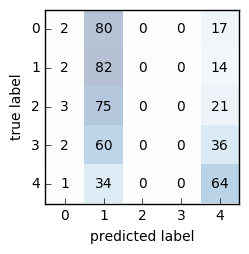

In [43]:
conf2 = conf.copy()
for i in range(0,len(conf2)):
    class_total = sum(conf2[i])
    for j in range(0, len(conf2)):
        conf2[i][j] = conf2[i][j]/class_total*100
        
fig, ax = plot_confusion_matrix(conf_mat=conf2)
plt.show()

### Optimization 

We used GridSearchCV as well as RandomizedSearchCV in order to improve our classifiers. GridSearchCV goes through every combination of params and finds the best combinations of parameters. It is "optimized by cross-validated grid-search over a parameter grid," which does warrant considerations of data snooping, but we believe GridSearchCV and RandomizedSearchCV will optimize our search while preventing overfitting.

RandomizedSearchCV had much faster computing time since it is less "exhaustive" than GridSearchCV. Randomized searching returns the best of a randomized set of parameters. Interestingly, our classifier predicted mostly the class 0 and class 4 in income as opposed to classes 1 and 4 from earlier. With the accuracy being so similar regardless of class 0 or 1 being predicted, perhaps our data is not nearly as correlated as we had hoped. The best method chosen by RandomizedSearch is steppest descent and the best method by GridSearch is Newton.  

In [53]:
params = {
    "optimize": ['newton', 'stochdesc', 'steepdesc'],
    "eta": [.0001, .001, .1, .5],
    "norm": [0, 1, 2, 3],
    "cost": [.0001, .001, .1, .5]
}

random_search = RandomizedSearchCV(LogRegClassifier(), params, n_jobs=-1)
%time %memit random_search.fit(X_train, list(y_train))
print('Best score: '+str(random_search.best_score_))
y_hat = random_search.predict(X_test)
conf = mt.confusion_matrix(y_test,y_hat)
print("Confusion matrix\n",conf)
print(random_search.best_params_)

peak memory: 304.54 MiB, increment: 89.72 MiB
CPU times: user 1min 4s, sys: 2.86 s, total: 1min 6s
Wall time: 1min 18s
Best score: 0.29470629252
Confusion matrix
 [[13197     0     0     0  2739]
 [13805     0     0     0  2415]
 [12294     0     0     0  3312]
 [10044     0     0     0  5883]
 [ 5639     0     0     0 10267]]
{'eta': 0.1, 'norm': 2, 'optimize': 'steepdesc', 'cost': 0.1}


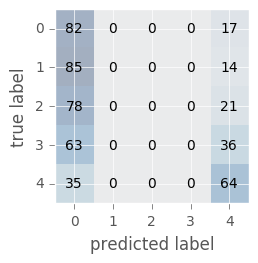

In [55]:
conf2 = conf.copy()
for i in range(0,len(conf2)):
    class_total = sum(conf2[i])
    for j in range(0, len(conf2)):
        conf2[i][j] = conf2[i][j]/class_total*100
        
fig, ax = plot_confusion_matrix(conf_mat=conf2)
plt.show()

With GridSearchCV, we had to reduce our set size for it to even compute at a resonable time. We ran the classifier on 50,000 records as opposed to 500,000 for the about the same accuracies as before. Due to long computation time, we added an image of our previous running result. 

In [ ]:
params = {
    "optimize": ['newton', 'stochdesc', 'steepdesc'],
    "eta": [.0001, .001, .1, .5],
    "norm": [0, 1, 2, 3],
    "cost": [.0001, .001, .1, .5]
}

cv = GridSearchCV(LogRegClassifier(), params, n_jobs=-1) # runs in parallel to get the job done as quick as possible
%time %memit cv.fit(X_train, list(y_train))
print('Best score: '+str(cv.best_score_))
y_hat = cv.predict(X_test)
conf = mt.confusion_matrix(y_test, y_hat)
print("Confusion matrix\n",conf)
print(cv.best_params_)

![GridSearch](https://raw.githubusercontent.com/egabrielsen/MachineLearning/master/Lab04/Screen%20Shot%202017-03-03%20at%2011.52.57%20PM.png)

## Deployment

In a machine-learning model, we recommend the use of scikit-learn's classifier. Their classifier is better than ours in both performance speed and accuracy, especially when using such a large dataset. Our classifier is slightly less memory intensive (especially with randomizedsearch), but scikit-learn is more sensitive to the class differences, produces more consistent results each time, and is the better choice hands down. The graphs below show the difference in run time and memory usage between our classifier and scikit-learn's for all of our computations above.

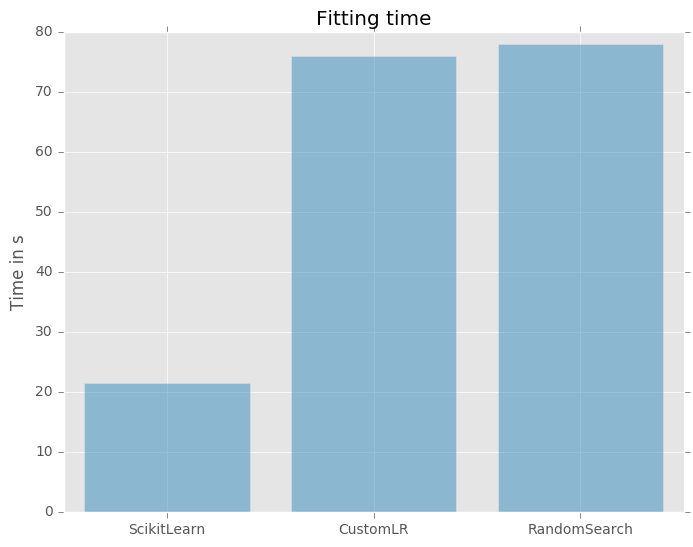

In [77]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

plt.style.use('ggplot')

objects = ('ScikitLearn', 'CustomLR', 'RandomSearch')
y_pos = np.arange(len(objects))
performance = [21.4, 76, 78]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time in s')
plt.title('Fitting time')
 
plt.show()


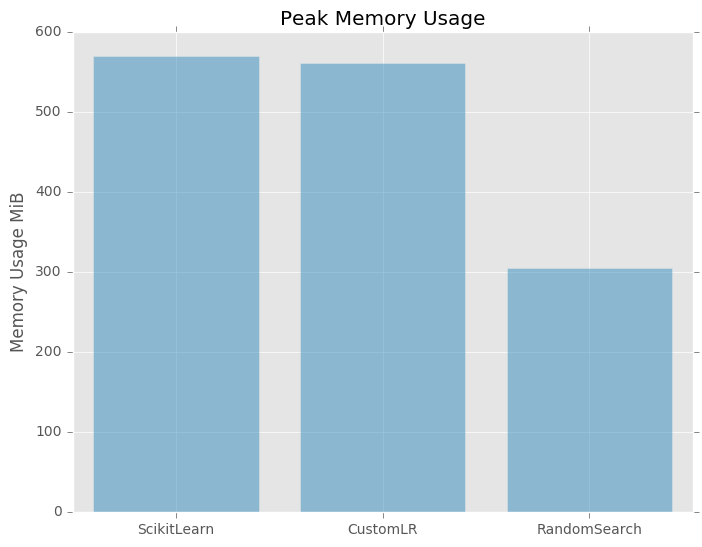

In [79]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

plt.style.use('ggplot')

objects = ('ScikitLearn', 'CustomLR', 'RandomSearch')
y_pos = np.arange(len(objects))
performance = [570.30, 561.18, 304.54]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Memory Usage MiB')
plt.title('Peak Memory Usage')
 
plt.show()
